# Understanding `pycheops` using data of KELT-11 II: Preparing the dataset

In this notebook, we demonstrate preparing the dataset, including detrending (or decorrelating) the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt

Found archive tgzfile /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 G magnitude : 7.83 +- 0.03
Light curve data loaded from  /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200-OPTIMAL.fits
Time stored relative to BJD = 2458918
Aperture radius used = 28 arcsec
UTC start:  2020-03-09T14:50:41
UTC end:    2020-03-10T04:44:34
Visit duration: 50033 s
Exposure time: 2 x 15.0 s
Number of non-flagged data points: 1535
Efficiency (non-flagged data): 92.0 %
Light curve corrected for flux from background stars
C_cut = 39629816
N(C > C_cut) = 4
Mean counts = 39495521.5
Median counts = 39511341.9
RMS counts = 46070.5 [1166 ppm]
Median standard error = 6331.7 [160 ppm]
Median background = 358931 e-/pxl
Mean contamination = 40.4 ppm
Mean smearing correction = 19.4 ppm
Predicted amplitude of ramp = 71 ppm


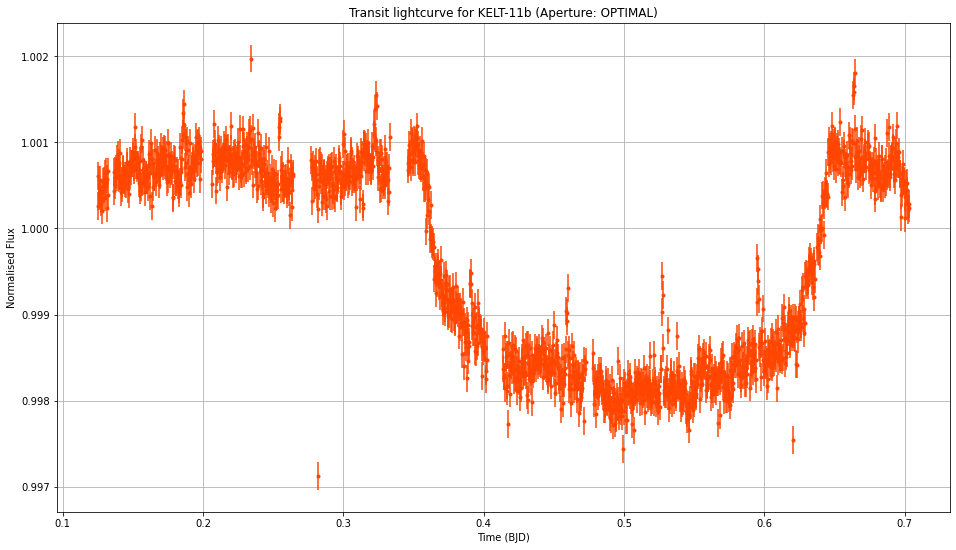

In [2]:
# Downloading data
dd = pycheops.Dataset('CH_PR300024_TG000101_V0200')
tim, fl, fle = dd.get_lightcurve(aperture='OPTIMAL', decontaminate=True, reject_highpoints=True)

# To clip outliers (I would, in general, not prefer using this)
# tim, fl, fle = dd.clip_outliers(clip=5)

# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)')
plt.grid()

## Stellar and Planetary properties

A knowledge of the stellar and planetary property of the system under investigation can proved to be useful while analysing the system. We can use some of the properties as priors in our analysis. In `pycheops` there are some in-build tools  available which ca go through the available stellar and planetary catalogues (like SWEET-Cat, or DACE) to give us the properties. Below, we show how to access such properties.

In [3]:
# For planetary properties
# This cell is copied from pycheops examples notebook

DACE = True  # Set true if you have access to the planet properties table through your .dacerc file

if DACE:    
    Kelt11b = pycheops.PlanetProperties('KELT-11b',query_dace=True)
else:
    from uncertainties import ufloat
    Kelt11b = pycheops.PlanetProperties('KELT-11b',query_dace=False,
                                    depth = ufloat(2200, 100),   # PPM
                                    width = ufloat(0.2974,0.0001),  # days
                                    ecosw=ufloat(-0.0040, 0.0490), 
                                    esinw=ufloat(0.0310, 0.0680),
                                    T0 = ufloat(2458260.168608, 0.000030),
                                    P = ufloat(4.73620495, 0.00000086))
    
print(Kelt11b)

2021-10-23 18:03:21,431 - ERROR - Forbidden. You do not have the permission to access these data


No matching planet in DACE-Planets.
List of valid planet_id keys:


2021-10-23 18:03:23,084 - ERROR - Forbidden. You do not have the permission to access these data


[]
Identifier : KELT-11b
T0 : 2458260.1686 +/- 0.0000 BJD       [TEPCat]
P :     4.7362050 +/- 0.0000009 days   [TEPCat]
depth :  2200.0000 +/- 100.0000 ppm         [TEPCat]
width :  0.2974 +/- 0.0100 days            [TEPCat]



Well..., apparently, I cannot (even after studying two semesters at Geneva) access DACE-Planets. No problem --- we have TEPCat at our service. We derived parameters from there. We can now try searching for the host star.

In [4]:
star = pycheops.StarProperties(dd.target)
print(star)

Identifier : KELT-11b
Coordinates: 10:46:49.74 -09:23:56.5
T_eff :  5370 +/-  50 K   [SWEET-Cat]
log g :  3.73 +/- 0.04    [SWEET-Cat]
[M/H] : +0.18 +/- 0.07    [SWEET-Cat]
log rho : -1.17 +/- 0.08  (solar units)
h_1 : 0.715 +/- 0.011     [Stagger]
h_2 : 0.442 +/- 0.050     [Stagger]



We have it! Here `h_1` and `h_2` are power2 law limb darkening coefficients.

## Renormalising the lightcurve

By a careful observation of the KELT-11 lightcurve, it can be observed that the out-of-transit values of the lightcurve is not equal to unity. So we may want to flatten the lightcurve using the `dataset.flatten` command as below,

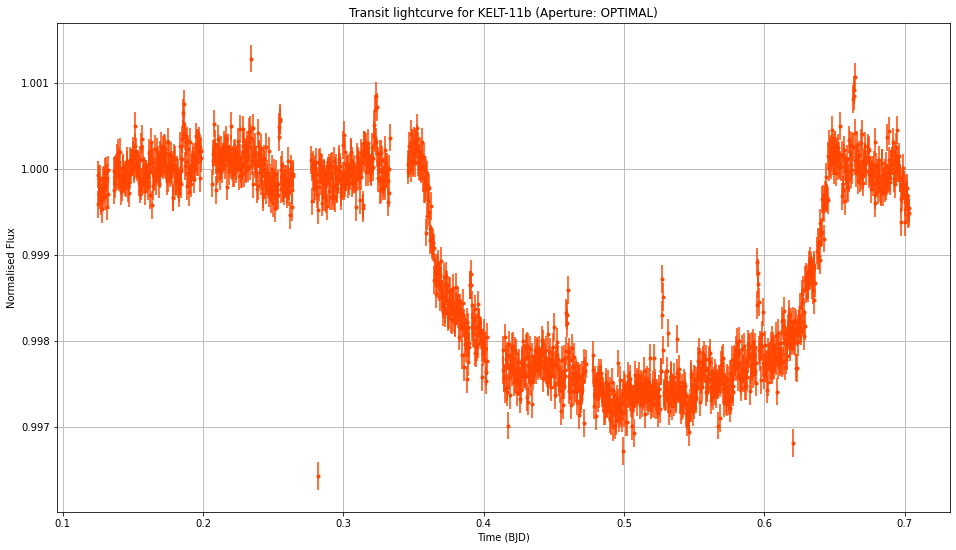

In [5]:
# This code is taken from the pycheops example notebook
P = Kelt11b.P.n
BJD_0 = Kelt11b.T0.n
cycle = round((dd.bjd_ref-BJD_0)/P)
T_0 = BJD_0 - dd.bjd_ref + cycle*P

D = Kelt11b.depth.n/1e6  # Depth stored in ppm
W = Kelt11b.width.n/P    # Width stored in days

if Kelt11b.f_c and Kelt11b.f_s:
    f_c = Kelt11b.f_c
    f_s = Kelt11b.f_s
else:
    # From Pepper et al., 2017
    ecosw = ufloat(-0.004,0.05099)
    esinw = ufloat(0.031,0.055)
    ecc = usqrt(ecosw**2+esinw**2)
    f_s = esinw/usqrt(ecc)  # f_s = sqrt(e)sin(omega) = e.sin(omega)/sqrt(e)
    f_c = ecosw/usqrt(ecc)  # f_c = sqrt(e)cos(omega) = e.cos(omega)/sqrt(e)


tim, fl, fle = dd.flatten(T_0, P*W)
# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)')
plt.grid()

## Detrending (or, decorrelating) the dataset

To perform this operation of detrending we may want to look at diagnostic report for this observations. The diagnostic report consist of various plots of flux as a function of several instrumental properties like roll angle of the spacecraft, centroid position etc. This would enable us to see if there is any trend going on with instruments so that we can take care of it. So, first let's see the diagnostic report...

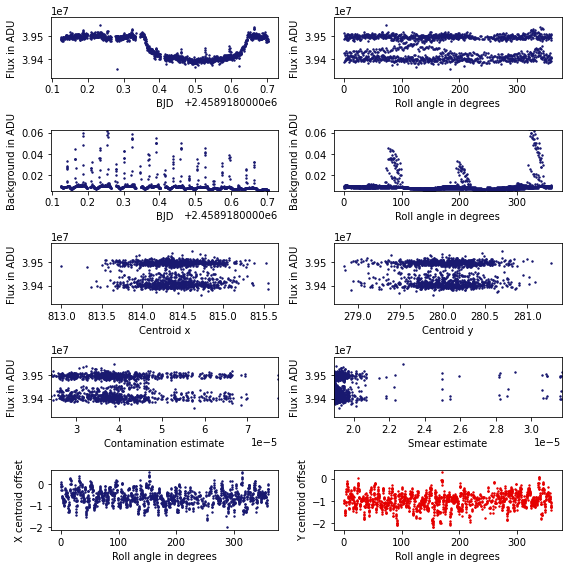

In [6]:
dd.diagnostic_plot()

### Ramp correction
A ramp in the flux is often observed, usually beginning the visit, in the lightcurves due to thermal effects (well, it primarily occurs due to small scale change in the shape of the PSF, which happens due to slightly more defocusing of the telescope. The main reason for the later is the thermal effects). The effect is well characterised for aperture radius between ~22 to 40 pixels. We can correct for this effect using the function `dataset.correct_ramp`.

Note that since this effect is well described only for a range of pixels, it is not advisable to make this correction if the aperture size is beyond this range.

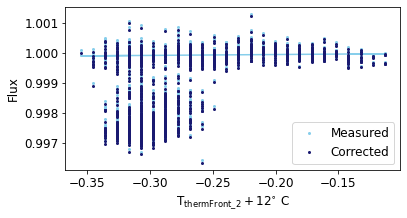

In [7]:
tim, fl, fle = dd.correct_ramp(plot=True)

### Should I decorrelate?

In [8]:
# Run the decorrelation tool to assess if there are any trends in the data
# that should be removed.
dd.should_I_decorr()

Decorrelate in dfdt dfdx dfdy dfdsinphi dfdcosphi dfdbg dfdcontam dfdsmear d2fdt2 d2fdx2 d2fdy2 dfdsin2phi dfdcos2phi using decorr, lmfit_transt, or lmfit_eclipse functions.


(-21628.656365871262,
 ['dfdt',
  'dfdx',
  'dfdy',
  'dfdsinphi',
  'dfdcosphi',
  'dfdbg',
  'dfdcontam',
  'dfdsmear',
  'd2fdt2',
  'd2fdx2',
  'd2fdy2',
  'dfdsin2phi',
  'dfdcos2phi'])

### Performing decorrelation

We can see above that, `Dataset.should_I_decorr` function suggests that several decorrelations should be done. Various parameters shows different correlations with different properties of the instrument. From $\texttt{pycheops-cookbook}$ I mention where each of these parameters belong:

- flux versus time: $\texttt{dfdt}$, $\texttt{d2fdt2}$
- flux versus x-centroid: $\texttt{dfdx}$, $\texttt{d2fdx2}$
- flux versus y-centroid: $\texttt{dfdy}$, $\texttt{d2fdy2}$
- flux versus roll angle: $\texttt{dfdsinphi}$, $\texttt{dfdcosphi}$, $\texttt{dfdsin2phi}$, $\texttt{dfdcos2phi}$, $\texttt{dfdsin3phi}$, $\texttt{dfdcos3phi}$
- flux versus background: $\texttt{dfdbg}$
- flux versus contamination: $\texttt{dfdcontam}$
- flux versus smear: $\texttt{dfdsmear}$

Note that not each of the parameters have same units (especially $\texttt{dfdt}$), therefore, one may want to take care while defining these parameters in analysis.

There are (I think) two ways to take care of these correlations --- we can either use `dataset.decorr` function to take care of these correlations, or we can do it in the later stage of fitting the data. There is a little advantage of doing this in a later stage of curve fitting: if we do at that point, we can see the effect of <i>adding</i> parameters to the fitting with Bayes' factors. We can even neglect additional parameters which are not supported by the data.

However, before jumping to the main fitting, we give an example of the usage of `dataset.decorr` method. We can do so by making boolean `True` for desired parameters described above as the argument of the `dataset.decorr` method. As an example, we try to decorrelate, to the first order, trends in the roll angle.

Fit Report
[[Model]]
    Model(factor)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 1504
    # variables        = 4
    chi-square         = 0.00144119
    reduced chi-square = 9.6079e-07
    Akaike info crit   = -20834.6922
    Bayesian info crit = -20813.4286
[[Variables]]
    c:           1.00238653 +/- 1.3923e-04 (0.01%) (init = 1)
    dfdt:        0 (fixed)
    d2fdt2:      0 (fixed)
    dfdbg:       0 (fixed)
    dfdcontam:   0 (fixed)
    dfdsmear:    0 (fixed)
    ramp:        13046.9244 +/- 496.486075 (3.81%) (init = 0)
    dfdx:        0 (fixed)
    dfdy:        0 (fixed)
    d2fdxdy:     0 (fixed)
    d2fdx2:      0 (fixed)
    d2fdy2:      0 (fixed)
    dfdcosphi:   2.8101e-05 +/- 3.4770e-05 (123.73%) (init = 0)
    dfdsinphi:   3.4233e-05 +/- 3.6908e-05 (107.81%) (init = 0)
    dfdcos2phi:  0 (fixed)
    dfdsin2phi:  0 (fixed)
    dfdcos3phi:  0 (fixed)
    dfdsin3phi:  0 (fixed)
[[Correlations]] (unreported corre

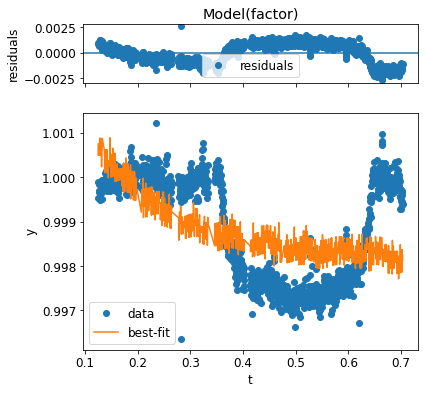

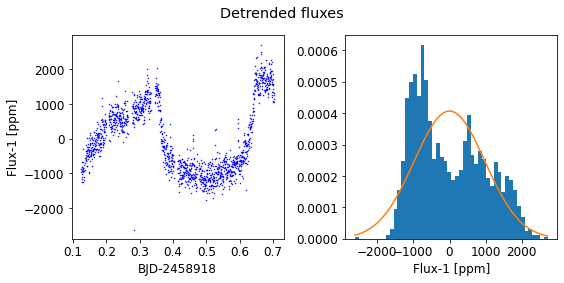

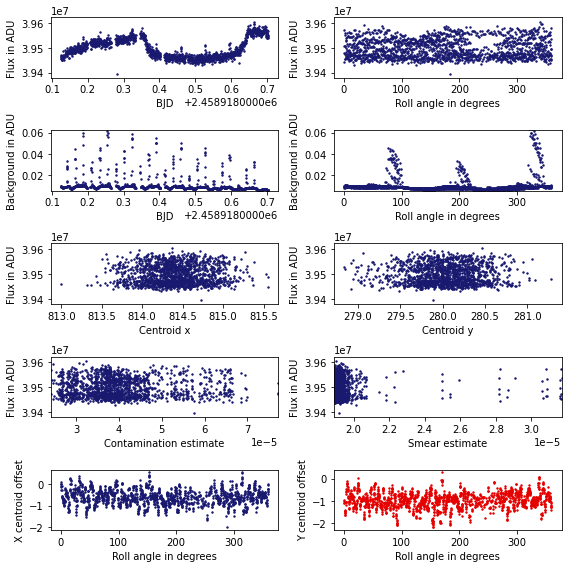

In [9]:
fl, fle = dd.decorr(dfdsinphi=True, dfdcosphi=True)
# Since sin(phi) and cos(phi) are the sinus and cosine of the roll angle, if one wants to perform this decorrelation, these two should be used in pair.
dd.diagnostic_plot()

Well, it indeed seem that, the decorrelation is performed (compare two diagnostic plots).

However, as said previously, we are not going to use this method --- instead, we will try to decorrelate while fitting the model only. That way we can have advantage of knowing Bayes' factor, so that we want include too many redundant parameters while modelling.

Below, we try to include one by one parameter in the model and see its effect on the fitting in form of the Bayes' factor.